In [48]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os 
import networkx as nx
import igraph as ig
from ts2vg import NaturalVG
from scipy.spatial.distance import euclidean
from networkx import to_numpy_array
import pandas as pd
import csv

0
1
2
3
4
5
0
1
2
3
4
5


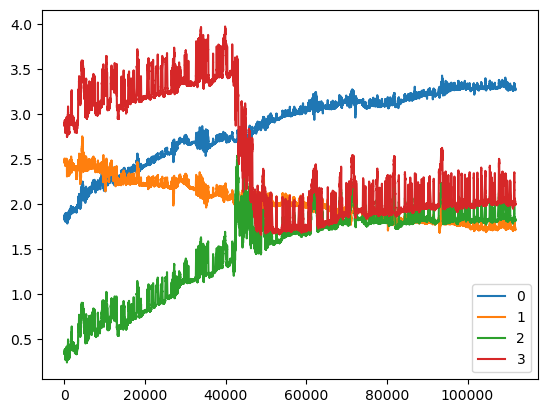

In [49]:
# data input
multichannel_timeseries = []
datadir = "../Multichannel\patient\\"
for each in os.listdir(datadir):
    temp = []
    df = pd.read_csv(datadir+each)
    for col in range(df.shape[1]):
        print(col)
        temp.append(df.iloc[:, col])
    multichannel_timeseries.append(temp)
# creates a list of lists of lists of timeseries

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot each list
i = 0
for each in multichannel_timeseries[0][1:5]:
    ax.plot(each, label=i)
    i+=1

# Add legend and labels
ax.legend()
# ax.set_xlabel('X-axis label')
# ax.set_ylabel('Y-axis label')
# ax.set_title('Title of plot')

# Display the plot
plt.show()


In [50]:
# convert time series into natural visibility graphes
# https://github.com/CarlosBergillos/ts2vg

def construct_visibilty_graph(ts):
    # builds natural visibility graph
    vg = NaturalVG()
    vg.build(ts)
    # converts to networkx graph format
    g = vg.as_networkx()
    return g

def get_degree_sequence(vg):
    # get [(node, degrees),...] from a vg
    # convert to dict
    # get values (the degrees)
    ds = list(dict(nx.degree(vg)).values())
    return ds

In [51]:
normalized_distance_matrices = []
TIMESTEP = 150
OVERLAP = 50
TS = multichannel_timeseries[0][0]
TRUNCATED = len(TS) % TIMESTEP

for ts in multichannel_timeseries[0][1:5]:
    # segment y_filtered into consecutive non-overlapping intervals
    segments = [ts[i:i+TIMESTEP] for i in range(0, len(ts)-TIMESTEP+1, TIMESTEP-OVERLAP)]

    # construct a visibility graph for each segment
    graphs = [construct_visibilty_graph(segment) for segment in segments]

    # compute feature vectors for each graph using degree centrality
    feature_vectors = [np.array(list(nx.degree_centrality(graph).values())) for graph in graphs]

    # define distance matrix D for each segment using Euclidean distance
    distance_matrices = []
    for i in range(len(feature_vectors)):
        D = np.zeros(len(feature_vectors))
        for j in range(len(feature_vectors)):
            D[j] = np.linalg.norm(feature_vectors[i]-feature_vectors[j])
        distance_matrices.append(D)

    # compute global distance matrix by averaging distances across all segments
    global_distance_matrix = np.vstack(distance_matrices)

    # normalize global distance matrix between 0 and 1
    normalized_distance_matrix = 1 - (global_distance_matrix - np.min(global_distance_matrix)) / (np.max(global_distance_matrix) - np.min(global_distance_matrix))
    print(np.array(normalized_distance_matrix).shape)

    normalized_distance_matrices.append(normalized_distance_matrix)

average_normalized_distance_matrix = np.mean(normalized_distance_matrices, axis=0)
print(type(average_normalized_distance_matrix))

# construct weighted graph C using normalized distance matrix as adjacency matrix
# threshold = 0.0  # set a threshold to remove weak edges
# C = nx.from_numpy_array(normalized_distance_matrix * (normalized_distance_matrix >= threshold))

C = nx.from_numpy_array(average_normalized_distance_matrix)

# Set edge weights to similarity values
for u, v, d in C.edges(data=True):
    d['weight'] = average_normalized_distance_matrix[u][v]
    
# Remove self-loops
C.remove_edges_from(nx.selfloop_edges(C))

weightedGraph = C

# Draw the weighted graph
# nx.draw(C)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 2, 5: 4, 6: 2, 7: 5, 8: 6, 9: 2, 10: 7, 11: 2, 12: 4, 13: 8, 14: 9, 15: 10, 16: 11, 17: 2, 18: 2, 19: 12, 20: 13, 21: 14, 22: 15, 23: 6, 24: 16, 25: 6, 26: 2, 27: 17, 28: 18, 29: 6, 30: 19, 31: 20, 32: 21, 33: 2, 34: 18, 35: 2, 36: 2, 37: 22, 38: 23, 39: 24, 40: 22, 41: 3, 42: 25, 43: 26, 44: 23, 45: 14, 46: 28, 47: 29, 48: 6, 49: 30, 50: 31, 51: 2, 52: 2, 53: 6, 54: 2, 55: 32, 56: 33, 57: 2, 58: 34, 59: 2, 60: 2, 61: 17, 62: 2, 63: 17, 64: 2, 65: 6, 66: 2, 67: 36, 68: 6, 69: 2, 70: 2, 71: 6, 72: 2, 73: 2, 74: 37, 75: 2, 76: 38, 77: 39, 78: 40, 79: 41, 80: 3, 81: 38, 82: 6, 83: 2, 84: 9, 85: 18, 86: 42, 87: 2, 88: 39, 89: 16, 90: 16, 91: 43, 92: 7, 93: 2, 94: 44, 95: 2, 96: 7, 97: 2, 98: 2, 99: 17, 100: 2, 101: 26, 102: 6, 103: 45, 104: 2, 105: 46, 106: 2, 107: 30, 108: 16, 109: 39, 110: 47, 111: 25, 112: 18, 113: 18, 114: 2, 115: 23, 116: 18, 117: 20, 118: 3, 119: 30, 120: 18, 121: 2, 122: 2, 123: 2, 124: 44, 125: 2, 126: 2, 127: 48, 128: 49, 129: 38, 130: 

C:\Users\ianja\AppData\Local\Temp\ipykernel_30172\3121351982.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


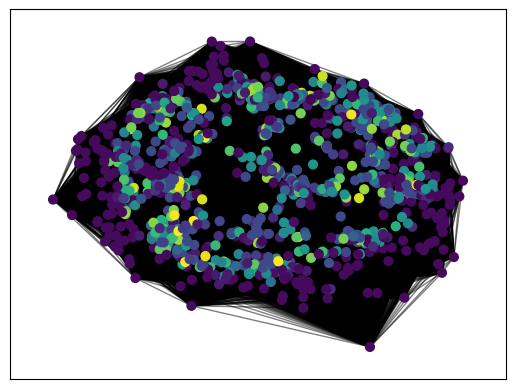

In [ ]:
# community detection (clustering) of weighted graphes
# https://github.com/taynaud/python-louvain

# To achieve a modular visualization of the clusters detected by the discussed method and their
# mutual connections, we used a force-directed algorithm, namely the Frushterman–Reingold layout,
# as a graphical representation.
# Finally, for specific unsupervised FSS purposes, we considered a representative parameter for
# each cluster. Such parameters were identified based on their importance within the communities,
# by considering the signals with highest total degree centrality in their respective groups.

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(weightedGraph, resolution=(1.02))

print(partition)

# draw the graph
pos = nx.spring_layout(weightedGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(weightedGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(weightedGraph, pos, alpha=0.5)
# plt.savefig("model.png", transparent=True)
plt.show()

# try averaging matrix across subjects, try concatenate signals end to end 

In [ ]:
import matplotlib.pyplot as plt
print(set(list(partition.values())))


#majority voting method for overlapping clusters
# Create the dictionary

TSFAKE = [*range(len(TS))]
SEGMENTSFAKE = [TSFAKE[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)] #(from 0 to last possible timestep, in steps of len of timestep (remove overlap))
occuranceTable = {i: [segmentNum for segmentNum in range(len(SEGMENTSFAKE)) if i in SEGMENTSFAKE[segmentNum]] for i in range(len(TS) - TRUNCATED) if any(i in seg for seg in SEGMENTSFAKE)}
# print(occuranceTable)
# occuranceTable = {}
# for i in range(len(TS) - TRUNCATED) :
#     indices = []
#     for j, seg in enumerate(SEGMENTSFAKE):
#         if i in seg:
#             indices.append(j)
#     if indices:
#         occuranceTable[i] = indices

majority_partition = {}
# iterate over time steps
for i in range(len(TS) - TRUNCATED):
    partitions = {} # dictionary to store frequency of partitions in current time step
    
    # iterate over segments in current time step
    for segmentNum in occuranceTable[i]:
        p = partition[segmentNum] # get partition of current segment
        if p not in partitions:
            partitions[p] = 1
        else:
            partitions[p] += 1
        
    # assign majority partition for current timestep
    majority = max(partitions, key=partitions.get)
    majority_partition[i] = majority

import colorsys
n_colors = len(set(list(partition.values())))  # number of colors to generate
colors = {}
for i in range(n_colors): # generates highly contrasting colors by incrementing hue
    hue = i / float(n_colors)
    saturation = 0.9
    value = 0.9
    (r, g, b) = colorsys.hsv_to_rgb(hue, saturation, value)
    colors[i] = (r, g, b)

for i in range(len(TS) - TRUNCATED):
    plt.plot(i, TS[i], marker='o', markersize=2, color=colors[majority_partition[i]])

    
plt.show()

# # each timestep section assigned color of respective partition
# for i in range(len(SEGMENTS)):
#     plt.plot(range(TIMESTEP*i, TIMESTEP*(i+1)), SEGMENTS[i], marker='o', markersize=2, color=colors[partition[i]])

# plt.show()
